In [38]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm_notebook
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_curve, auc,\
precision_score
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import plot_confusion_matrix


### Reading the data as a dataframe

In [3]:
data = pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [4]:
data.shape

(6362620, 11)

In [5]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


We are given a data of financial transactions which span over a period of approximately one month. Some of these transactions are fradulent. Let's take a look at the features/variables of this dataset.

* **step** - Integer value. Maps a unit of time in real world. A step of time is an hour.
* **type** - Categorical value. Shows type of transactions.
* **amount** - Float. Represents amount of the transaction in local currency.
* **nameOrig** - String. Customer who initiated the transaction.
* **oldbalanceOrg** - Float. Initial balance of the initiator before the transaction.
* **newbalanceOrig** - Float. New balance of the initiator after the transaction.
* **nameDest** - String. Customer who is the recipient of the transaction.
* **oldbalanceDest** - Float. Initial balance of the recipient before the transaction.
* **newbalanceDest** - Float. New balance of the recipient after the transaction.
* **isFraud** - Binary. Used to identify fraud transactions from the rest.
* **isFlaggedFraud** - Binary. Used to determine if the transaction is flagged fraud.

### Checking for missing data

In [6]:
data.isnull().values.any()

False

### Basic stats and summary of data

In [7]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


## Data Description and takeaways

1. There are approximately 6 million records
2. There are 11 variables/features
3. The data has no missing values
4. The maximum transaction is less than 100 million in the currency.
5. We've no data about the recipients where their name starts with 'M' i.e Merchants
6. There are no missing values in the data

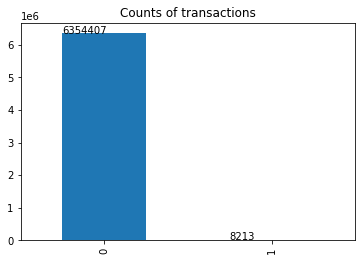

0    6354407
1       8213
Name: isFraud, dtype: int64

In [8]:
axes = pd.value_counts(data['isFraud']).plot(kind = 'bar', title= 'Counts of transactions')
for bar in axes.patches:
    x = str(format(int(bar.get_height())))
    y = (bar.get_x(), bar.get_height())
    axes.annotate(x,y)
plt.show()

data['isFraud'].value_counts()

As seen above, the data is heavily skewed with about 0.12% of transactions consisting of fraud

## step over time 

As seen in the below histogram, most of the transactions take place in approximately the first 400 hours i.e in the first 16-17 days.

<AxesSubplot:>

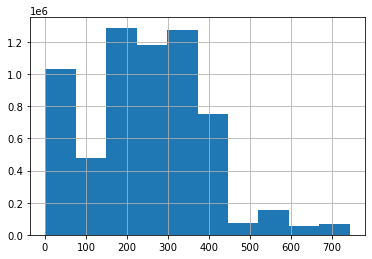

In [9]:
data['step'].hist()

### type of transactions

Let's take a look at the types of transactions

<AxesSubplot:>

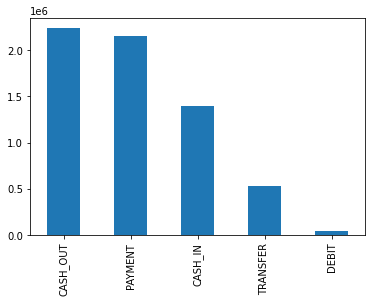

In [10]:
data['type'].value_counts().plot(kind='bar')

Most of the transactions are of the types 'CASH_OUT', 'PAYMENT', 'CASH_IN'

### Types of transactions for fraud

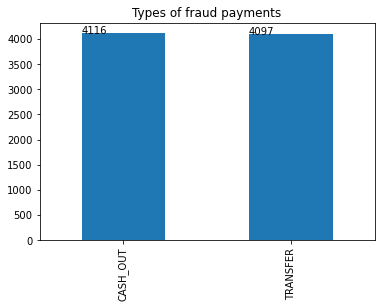

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64

In [11]:
axes = pd.value_counts(data[data["isFraud"] == 1]['type']).plot(kind = 'bar', title= 'Types of fraud payments')
for bar in axes.patches:
    x = str(format(int(bar.get_height())))
    y = (bar.get_x(), bar.get_height())
    axes.annotate(x,y)
plt.show()

data[data["isFraud"] == 1]['type'].value_counts()

In [12]:
valid = data[data["isFraud"] == 0]
fraud = data[data["isFraud"] == 1]

As seen above, the fraud data has only two types of payments viz. 'cash_out' and 'transfer'
Let's remove the rows with other types of payments

In [13]:
data = data[(data['type'] == 'CASH_OUT') | (data['type'] == 'TRANSFER')]
valid = valid[(valid['type'] == 'CASH_OUT') | (valid['type'] == 'TRANSFER')]

## Assumptions

Let's make some assumptions
1. We've no negative values in the dataset
2. Most of the transactions have no balance errors in them i.e old balance + amount = new balance

## check negative values

In [14]:
numeric_columns = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
for col in tqdm_notebook(numeric_columns):
    current = data[col].values.flatten()
    number_negative = sum(current < 0)
    if number_negative:
        print(col)

  0%|          | 0/5 [00:00<?, ?it/s]

Our first assumption of not having negative values holds

## check percent of transactions with error

In [15]:
count_err_trans = (data['oldbalanceOrg'] + data['amount'] != data['newbalanceOrig']) | (data['oldbalanceDest'] + data['amount'] != data['newbalanceDest'])
print("Percentage : " + str(100*sum(count_err_trans)/data.shape[0]))

Percentage : 99.99942246794608


Our second assumption doesn't hold. That is almost all the transactions have errors in their balances

## Error in the balances

Now let's see if the error in the balance of either origin or destination has different stats for fraud and valid transactions

### adding features

In [16]:
data['errorOrig'] = data['newbalanceOrig'] + data['amount'] - data['oldbalanceOrg']
data['errorDest'] = data['newbalanceDest'] + data['amount'] - data['oldbalanceDest']

#### modify fraud and valid subsets to accomodate new features

In [17]:
valid = data[data["isFraud"] == 0]
fraud = data[data["isFraud"] == 1]

### Compare error of Origin for Valid and Fraud transactions

In [18]:
print("VALID Origin Transactions Error: ")
print(valid['errorOrig'].describe())
print('\n')
print("FRAUD Origin Transactions Error: ")
print(fraud['errorOrig'].describe())

VALID Origin Transactions Error: 
count    2.762196e+06
mean     2.868035e+05
std      8.763752e+05
min     -1.000000e-02
25%      5.261343e+04
50%      1.442008e+05
75%      2.804663e+05
max      9.244552e+07
Name: errorOrig, dtype: float64


FRAUD Origin Transactions Error: 
count    8.213000e+03
mean     1.069233e+04
std      2.651461e+05
min     -7.450581e-09
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+07
Name: errorOrig, dtype: float64


As seen above, for valid transactions, the error seems to be large for most of the observations.
On the other hand, the error for fraud transactions seems to be close to zero. This is evident because about 75% of fraud data has error equal to or close to zero.

### Compare error of Destination for Valid and Fraud transactions

In [19]:
print("VALID Destination Transactions Error: ")
print(valid['errorDest'].describe())
print('\n')
print("FRAUD Destination Transactions Error: ")
print(fraud['errorDest'].describe())

VALID Destination Transactions Error: 
count    2.762196e+06
mean     6.591413e+05
std      1.989672e+06
min     -9.385210e+06
25%      1.667985e+05
50%      3.496661e+05
75%      6.325571e+05
max      1.848910e+08
Name: errorDest, dtype: float64


FRAUD Destination Transactions Error: 
count    8.213000e+03
mean     2.203425e+06
std      3.869000e+06
min     -1.897563e+05
25%      1.760074e+05
50%      6.280336e+05
75%      2.183180e+06
max      2.411357e+07
Name: errorDest, dtype: float64


We can't seem to find any differences in the valid and fraud transactions just by looking at these statistics. 
Let's try plotting the errors

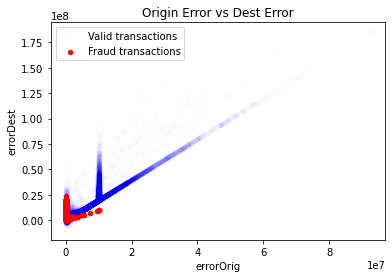

In [20]:
axes = plt.subplot()
plt.title('Origin Error vs Dest Error')
valid_plot = valid.plot(x='errorOrig', y='errorDest', color = "blue", kind='scatter',alpha=0.01, ax = axes, label='Valid transactions')
fraud_plot = fraud.plot(x='errorOrig', y='errorDest', color = "red", kind='scatter',ax = axes, label='Fraud transactions')
plt.show()

As seen above, all the fraud transactions have a Dest error less than equal to 0.25

### Let's check if we need the isFlaggedFraud feature

In [21]:
print("Total fraud transactions :", len(fraud))
print("Total fraud transactions flagged as fraud : ", len(fraud[fraud['isFlaggedFraud']==1]))

Total fraud transactions : 8213
Total fraud transactions flagged as fraud :  16


As the isFlaggedFraud only manages to correctly flag 16 transactions, we'll drop it

In [22]:
fraud = fraud.drop(["isFlaggedFraud"], 1)
valid = valid.drop(["isFlaggedFraud"],1)
data = data.drop(["isFlaggedFraud"],1)

### Let's check if we need nameOrig and nameDest

In [23]:
print("Number of unique names in Origin :",len(set(data['nameOrig'])))
print("Number of unique names in Dest :", len(set(data['nameDest'])))
print("Total number of rows :", len(data))

Number of unique names in Origin : 2768630
Number of unique names in Dest : 509565
Total number of rows : 2770409


Since, majority of the names in Origin and Dest are unique, we can drop these features

In [24]:
fraud = fraud.drop(["nameOrig","nameDest"], 1)
valid = valid.drop(["nameOrig","nameDest"],1)
data = data.drop(["nameOrig","nameDest"],1)

## Further analysis of the 'step' feature 

Earlier, we had observed the step in relation to the entirety of the given time span.
Now, let's see if we determine a pattern in the transactions by hours of a day.

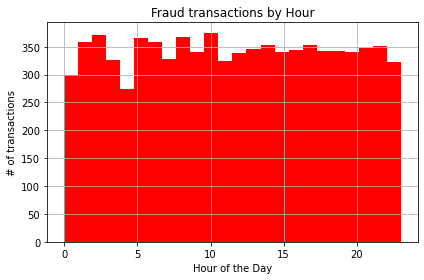

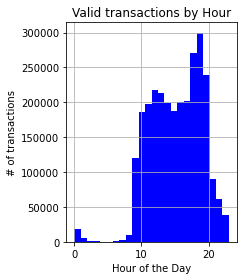

In [25]:
fraud_hour = fraud['step'] % 24
valid_hour = valid['step'] % 24

fraud_hour.hist(bins=24, color="red")
plt.title('Fraud transactions by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel("# of transactions")
plt.tight_layout()
plt.show()

plt.subplot(1, 2, 2)
valid_hour.hist(bins=24, color="blue")
plt.title('Valid transactions by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel("# of transactions")

plt.tight_layout()
plt.show()

As we can see, the fraud transactions don't take place during particular hours of the day.
However, the valid transactions take place mostly between hour 10 and hour 20.
Let's add this feature to our dataset.

In [26]:
data['hour'] = data['step'] % 24

## Data cleaning - convert categorical values 

Lastly, let's convert the categorical values i.e type into numerical values using One-hot encoding

In [27]:
data = pd.get_dummies(data,prefix=['type'])

Let's take a look at hour final dataset for prediction

In [28]:
data.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errorOrig,errorDest,hour,type_CASH_OUT,type_TRANSFER
2,1,181.00,181.0,0.0,0.0,0.00,1,0.00,181.00,1,0,1
3,1,181.00,181.0,0.0,21182.0,0.00,1,0.00,-21001.00,1,1,0
15,1,229133.94,15325.0,0.0,5083.0,51513.44,0,213808.94,275564.38,1,1,0
19,1,215310.30,705.0,0.0,22425.0,0.00,0,214605.30,192885.30,1,0,1
24,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,300850.89,3024591.78,1,0,1


## Check for correlation in the features

Let's see if we need can find any correlated features so that we can perform PCA to reduce the dimensions

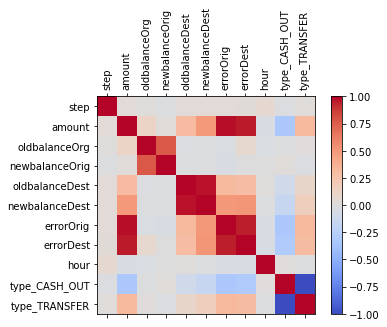

In [29]:
corr = data.drop("isFraud",1).corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.drop("isFraud",1).columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.drop("isFraud",1).columns)
ax.set_yticklabels(data.drop("isFraud",1).columns)
plt.show()

The correlation can be seen between the following pairs: 
1. errorOrig and amount
2. errorDest and amount
3. oldbalanceDest and newbalanceDest
4. oldbalanceOrg and newbalanceOrig

But all these features are important as we've seen above

### Normalizing and splitting data

In [30]:
X = data.drop(['isFraud'],1)
Y = data['isFraud']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Random Forest

In [31]:
# Train model
rf = RandomForestClassifier(n_estimators=15, oob_score=True, class_weight='balanced', n_jobs=-1, verbose=True)
fit = rf.fit(X_train, Y_train)
 
# Predict on testing set
predictionsRF = rf.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   39.3s finished
/Users/paurax/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/paurax/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    0.4s finished


In [32]:
# Evaluating model
CM_RF = confusion_matrix(Y_test,predictionsRF)
CR_RF = classification_report(Y_test,predictionsRF)
fprRF, recallRF, thresholdsRF = roc_curve(Y_test, predictionsRF)
AUC_RF = auc(fprRF, recallRF)

resultsRF = {"Confusion Matrix":CM_RF,"Classification Report":CR_RF,"Area Under Curve":AUC_RF}

## Evaluation of the Random Forest

In [37]:
# showing results from Random Forest

for measure in resultsRF:
    print(measure,": \n",resultsRF[measure])

Confusion Matrix : 
 [[690597      0]
 [    10   1996]]
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    690597
           1       1.00      1.00      1.00      2006

    accuracy                           1.00    692603
   macro avg       1.00      1.00      1.00    692603
weighted avg       1.00      1.00      1.00    692603

Area Under Curve : 
 0.9975074775672981


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    0.3s finished


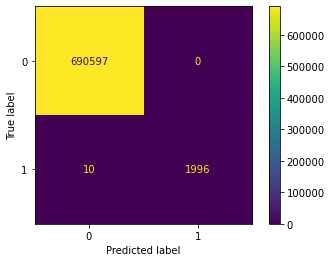

In [33]:
plot_confusion_matrix(rf, X_test, Y_test)  
plt.show()  

## eXtreme Gradient Boosting(XGB) Trees

In [34]:
# Train model
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum()) # for unbalanced datasets, these weights are recommended
XGB = XGBClassifier(max_depth=3, scale_pos_weight=weights, n_jobs=-1, learning_rate=0.1)
    
fitted_vals = XGB.fit(X_train, Y_train)
 
# Predict on testing set
predictionsXGB = XGB.predict(X_test)

/Users/paurax/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:57:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## Evaluation of the XGB

In [35]:
# Evaluating model
CM_XGB = confusion_matrix(Y_test,predictionsXGB)
CR_XGB = classification_report(Y_test,predictionsXGB)
fprXGB, recallXGB, thresholds_XGB = roc_curve(Y_test, predictionsXGB)
AUC_XGB = auc(fprXGB, recallXGB)
resultsXGB = {"Confusion Matrix":CM_XGB,"Classification Report":CR_XGB,"Area Under Curve":AUC_XGB}

# showing results from Extreme Gradient Boosting
for measure in resultsXGB:
    print(measure,": \n",resultsXGB[measure],"\n")

Confusion Matrix : 
 [[690367    230]
 [     5   2001]] 

Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    690597
           1       0.90      1.00      0.94      2006

    accuracy                           1.00    692603
   macro avg       0.95      1.00      0.97    692603
weighted avg       1.00      1.00      1.00    692603
 

Area Under Curve : 
 0.998587216195222 



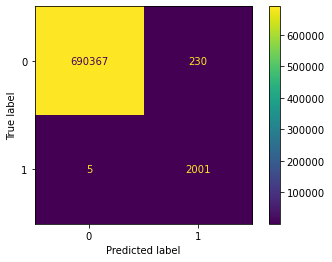

In [36]:
plot_confusion_matrix(XGB, X_test, Y_test)  
plt.show()  

## Analysis of the results and observations

Both the models performed really well for the valid transactions.
But Random Forest turned out to be a bit better for predicting the frad transactions.

This can be made clearer by taking a look at the Confusion matrices of both the models.
Random Forest has correctly predicted all the fradulent transactions whereas XGB tree has had a few misclassifiactions.

### ROC Curves for both the models

#### Random Forest ROC

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    0.4s finished


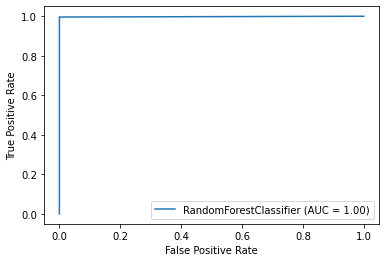

In [39]:
metrics.plot_roc_curve(rf, X_test, Y_test)  
plt.show()   

#### XGB ROC

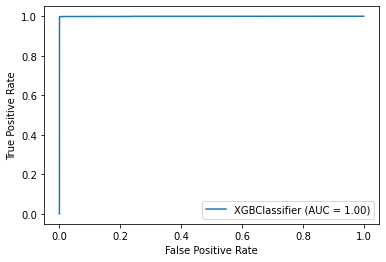

In [40]:
metrics.plot_roc_curve(XGB, X_test, Y_test)  
plt.show()   

Both the ROC curves for the models are similar so let's take a look at their AUC(area under the curve) values

### AUC Comparision

In [44]:
print("AUC for Random Forest :", AUC_RF)
print("AUC for XGB :", AUC_XGB)

AUC for Random Forest : 0.9975074775672981
AUC for XGB : 0.998587216195222


#### Occam's Razor prinicple

The AUC for XGB is better than the Random Forest but not by much. But looking at the results and considering the Occam's Razor Rule i.e prefer the simpler model when performance is similar, I'd prefer Random Forsest for this Dataset